# Pruebas T, parte 1

Para realizar las pruebas t con inferencia Bayesiana el método más sencillo es utilizar `pingouin` que produce por defecto factores de Bayes (BF) además del valor p frecuentista.


## Librerías y datos

Utilizaremos los `palmer penguins` que ya hemos revisado en el curso.


In [4]:
import pandas as pd
import pingouin as pg
import seaborn as sns

data = pg.read_dataset('penguins')
data.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Biscoe,37.8,18.3,174.0,3400.0,female
1,Adelie,Biscoe,37.7,18.7,180.0,3600.0,male
2,Adelie,Biscoe,35.9,19.2,189.0,3800.0,female
3,Adelie,Biscoe,38.2,18.1,185.0,3950.0,male
4,Adelie,Biscoe,38.8,17.2,180.0,3800.0,male


## Visualización de grupos.

Probemos la forma más sencilla del análisis comparando `body_mass_g` de acuerdo a la variable `sex`.

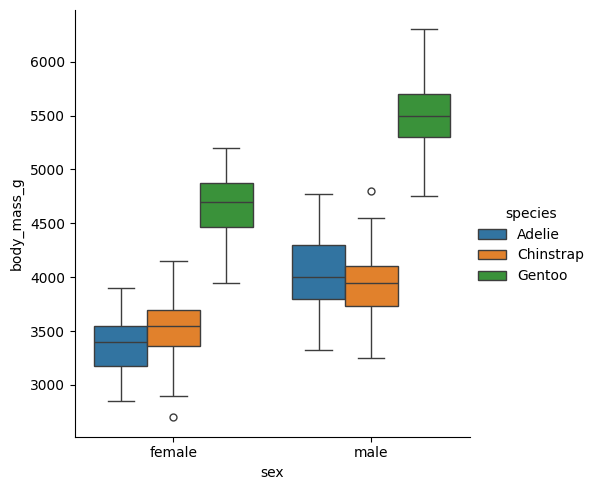

In [6]:
clean_data = data.dropna(subset=['body_mass_g', 'sex'])

sns.catplot(clean_data, x='sex', y='body_mass_g', hue='species', kind='box')

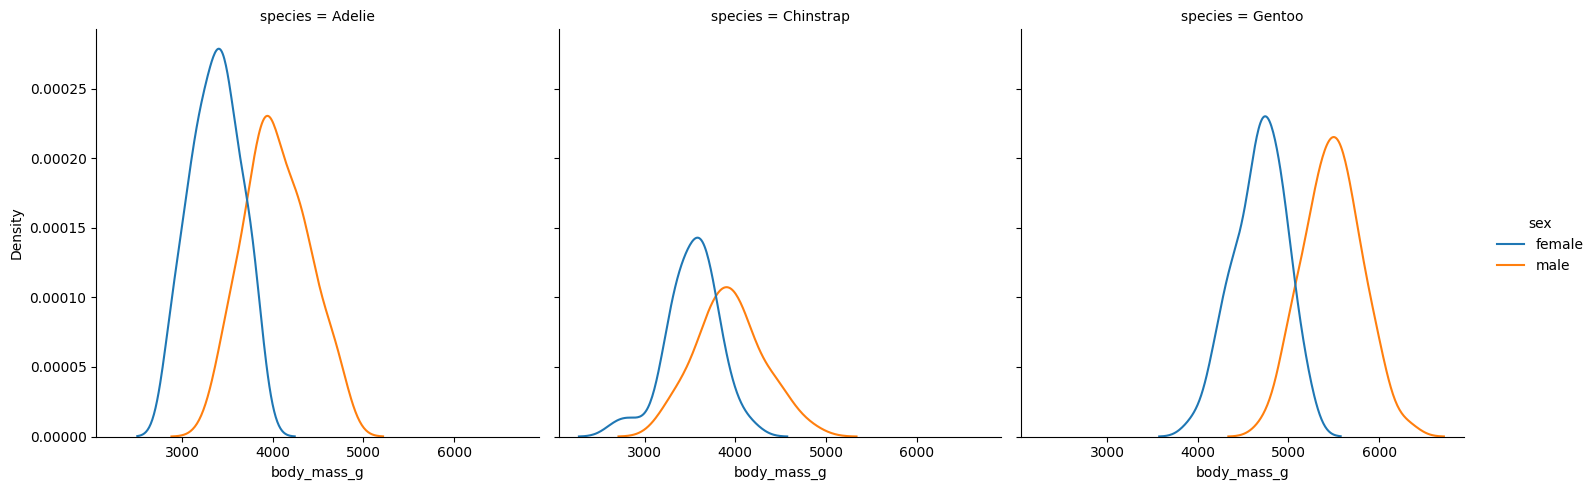

In [18]:
sns.displot(
    clean_data,
    x='body_mass_g',
    hue='sex',
    kind='kde',
    col='species'
)

Vemos que efectivamente hay una diferencia en peso corporal con respecto al sexo y a la especie.
Probemos ahora el análisis.

Antes de ejecutar el análisis, conviene leer la documentación de la función. Te sugiero leerlo en la página de pingouin, pero también podemos verlo con la función `help`. 

In [41]:
help(pg.ttest)

Help on function ttest in module pingouin.parametric:

ttest(
    x,
    y,
    paired=False,
    alternative='two-sided',
    correction='auto',
    r=0.707,
    confidence=0.95
)
    T-test.

    Parameters
    ----------
    x : array_like
        First set of observations.
    y : array_like or float
        Second set of observations. If ``y`` is a single value, a one-sample
        T-test is computed against that value (= "mu" in the t.test R
        function).
    paired : boolean
        Specify whether the two observations are related (i.e. repeated
        measures) or independent.
    alternative : string
        Defines the alternative hypothesis, or tail of the test. Must be one of
        "two-sided" (default), "greater" or "less". Both "greater" and "less" return one-sided
        p-values. "greater" tests against the alternative hypothesis that the mean of ``x``
        is greater than the mean of ``y``.
    correction : string or boolean
        For unpaired two sample

In [16]:
condition = (clean_data['sex'] == 'female')
fem = clean_data[condition]['body_mass_g']
male = clean_data[~condition]['body_mass_g'] # operador not

# prueba t

pg.ttest(fem, male)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-8.554537,323.895881,two-sided,4.793891e-16,"[-840.58, -526.25]",0.936205,1.142e+13,1.0


El resultado incluye el estadístico t, los grados de libertad, el tipo de hipótesis, el valor p, el intervalo de confianza para la diferencia de medias, el tamaño del efecto (d de Cohen), el factor de Bayes $BF_{10}$, y el poder post-hoc del análisis.

En este caso, se utilizó un valor por defecto de $r=0.707$, que corresponde al parámetro de escala de una distribución Cauchy centrada en 0, utilizada como prior sobre el tamaño del efecto bajo la hipótesis alternativa.

El factor r, bajo la distribución Cauchy del tamaño del efecto se define con la siguiente fórmula, el factor por defecto fue descrito por Rouder (2009) y se utiliza en muchas implementaciones en Python, R, JASP, etc. Se calcula de la siguiente forma:

$$
\frac{1}{\sqrt{2}} \approx 0.707
$$

> Rouder, J.N., Speckman, P.L., Sun, D., Morey, R.D., Iverson, G., Bayesian t tests for accepting and rejecting the null hypothesis. Psychon. Bull. Rev. 16, 225–237. https://doi.org/10.3758/PBR.16.2.225

Pero si contáramos con estudios previos que sugirieran un tamaño del efecto diferente, el análisis debería contemplarlo. Analicemos la diferencia global del peso entre los Chinstrap y los Adelie.


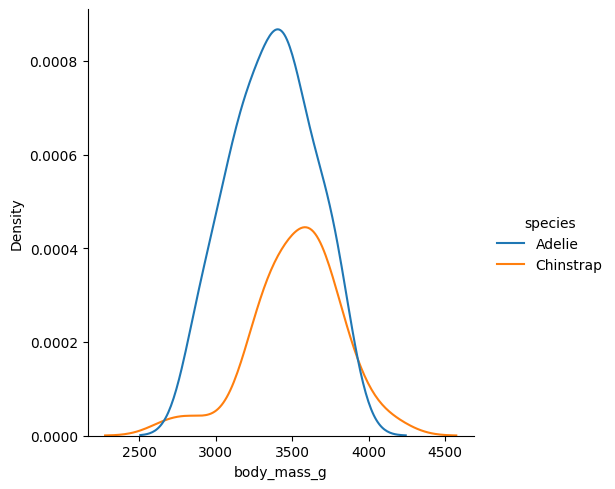

In [33]:
condition = (clean_data['sex'] == 'female') & (clean_data['species'] != 'Gentoo')
sns.displot(clean_data[condition], x='body_mass_g', hue='species', kind='kde')

Vemos que la diferencia es minúscula. Veamos cómo cambia el factor de Bayes con diferentes valores de r


In [47]:
chinstrap = clean_data[clean_data['species'] == 'Chinstrap']['body_mass_g']
adelie = clean_data[clean_data['species'] == 'Adelie']['body_mass_g']


result = pd.concat([
    pg.ttest(adelie, chinstrap, r=r).assign(r=r)
    for r in [0.1, 0.5, 0.707, 1]
])

result

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,r
T-test,-0.44793,154.032619,two-sided,0.654833,"[-145.66, 91.82]",0.06168,0.651,0.070266,0.100
T-test,-0.44793,154.032619,two-sided,0.654833,"[-145.66, 91.82]",0.06168,0.238,0.070266,0.500
T-test,-0.44793,154.032619,two-sided,0.654833,"[-145.66, 91.82]",0.06168,0.175,0.070266,0.707
T-test,-0.44793,154.032619,two-sided,0.654833,"[-145.66, 91.82]",0.06168,0.126,0.070266,1.000


:::{note}
El código anterior utiliza una comprensión de lista, puedes ver cómo funciona [aquí](#comprensiones-target).
:::

Observamos que el valor p no alcanza significación estadística, y que el $BF_{10}$ proporciona evidencia moderada a fuerte a favor de la hipótesis nula $H_0: \text{Peso}{\text{Adelie}} = \text{Peso}{\text{Chinstrap}}$, incluso al usar un valor ingenuo de $r = 0.5$.

## Interpretación de $BF_{10}$
```{figure} Interpretation-of-Bayes-factors_W640.jpg
:name: Interpretación de factor Bayes.

Tabla de referencia para los diferentes puntos de corte del Factor de Bayes.

Imagen reproducida bajo los términos de la licencia CC BY 4.0.

Garnett, Claire & Michie, Susan & West, Robert & Brown, Jamie. (2019). Updating the evidence on the effectiveness of the alcohol reduction app, Drink Less: using Bayes factors to analyse trial datasets supplemented with extended recruitment. F1000Research. 8. 114. 10.12688/f1000research.17952.2. 
```

## Ejercicios
1. Aplica lo aprendido con tus propios datos.
2. Analiza la diferencia en el ancho del pico de acuerdo al sexo.